# Imports

In [ ]:
import ray

ray.shutdown()

In [68]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample tick dates

In [69]:
from tqdm import tqdm
from tick_sampler import streaming_tick_sampler, stacked, labels
from tick_filter import streaming_tick_filter
from data_model import arrow_dataset, s3_backend
import main

thresh = {
    # meta params
    'symbol': 'GLD',
    'start_date': '2020-11-10',
    'end_date': '2020-11-15',
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 17,  # 11
    'mad_diff': 'simple',
    'jma_winlen': 7,
    'jma_power': 2,
    # time batcher
    'batch_freq': '2s',
    # bar sampler params
    'renko_return': 'price_jma_return',
    'renko_size': 0.1,  # for simple runs
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'renko_range_min_pct_value': 0.03,  # X% of symbol value to enforc min renko size
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [ ]:
symbs = s3_backend.list_symbols('trades')
symbs

In [88]:
tdf = s3_backend.fetch_date_df(symbol=thresh['symbol'], date=thresh['start_date'], tick_type='trades')

GLD 2020-11-10 trying to get data from local file...


In [89]:
tdf

,sequence,trade_id,exchange_id,price,size,conditions,irregular,sip_dt,exchange_dt
0,412101,52983525027896,11,177.059998,61,"[12, 37]",False,2020-11-10 09:00:00.010560512,2020-11-10 09:00:00.010534144
1,412301,62879129949512,12,177.059998,1,"[12, 37]",False,2020-11-10 09:00:06.621574656,2020-11-10 09:00:06.621146782
2,412401,52983525027905,11,177.029999,1,"[12, 37]",False,2020-11-10 09:00:13.264915712,2020-11-10 09:00:13.264885760
3,412501,52983525027906,11,177.029999,1,"[12, 37]",False,2020-11-10 09:00:18.607687936,2020-11-10 09:00:18.607662848
4,412601,52983525027907,11,177.029999,1,"[12, 37]",False,2020-11-10 09:00:22.645199616,2020-11-10 09:00:22.645171456
...,...,...,...,...,...,...,...,...,...
77499,89417001,52983543777107,11,176.320007,130,[12],False,2020-11-11 00:58:15.727492608,2020-11-11 00:58:15.727465472
77500,89417701,52983543777108,11,176.289993,1,"[12, 37]",False,2020-11-11 00:58:57.888369664,2020-11-11 00:58:57.888342016
77501,89417801,52983543777109,11,176.289993,2,"[12, 37]",False,2020-11-11 00:58:57.888374272,2020-11-11 00:58:57.888342016
77502,89429901,52983543777608,11,175.660004,0,"[38, 41]",True,2020-11-11 01:00:00.002009856,2020-11-11 01:00:00.001837824


In [ ]:
tick_filter = streaming_tick_filter.StreamingTickFilter(thresh)

tick_sampler = streaming_tick_sampler.StreamingTickSampler(thresh)


for tick in tqdm(tdf.itertuples(), total=tdf.shape[0]):
    
    tick_filter.update(
        price=tick.price, 
        volume=tick.size, 
        sip_dt=tick.sip_dt, 
        exchange_dt=tick.exchange_dt, 
        conditions=tick.conditions
    )
    # get current 'filtered' tick
    ftick = tick_filter.ticks[-1]
    
    # sample 'clean' ticks
    if ftick['status'] == 'clean: market-open':

        tick_sampler.update(
            close_at=ftick['nyc_dt'],
            price=ftick['price'],
            volume=ftick['volume'],
            side=ftick['side'],
            price_jma=ftick['price_jma']
        )
    

In [92]:
tdf = pd.DataFrame(tick_filter.ticks)

bdf = pd.DataFrame(tick_sampler.bars)

In [78]:
stream_samp = streaming_tick_sampler.StreamingTickSampler(thresh)

tdfc = tdf[tdf.status.str.startswith('clean')]

for tick in tqdm(tdfc.itertuples(), total=df.shape[0]):
    
    stream_samp.update(
        close_at=tick.nyc_dt,
        price=tick.price,
        volume=tick.volume,
        side=tick.side,
        price_jma=tick.price_jma
    )

bdf = pd.DataFrame(stream_samp.bars)
# bdf

76922it [00:03, 19413.57it/s]                           


<AxesSubplot:>

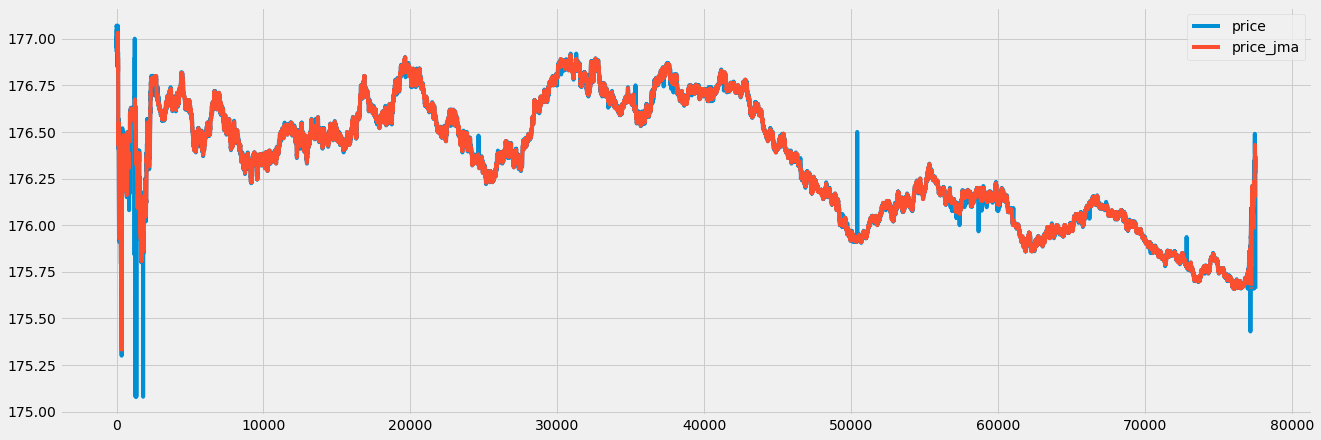

In [95]:
tdf[['price', 'price_jma']].plot()

<AxesSubplot:>

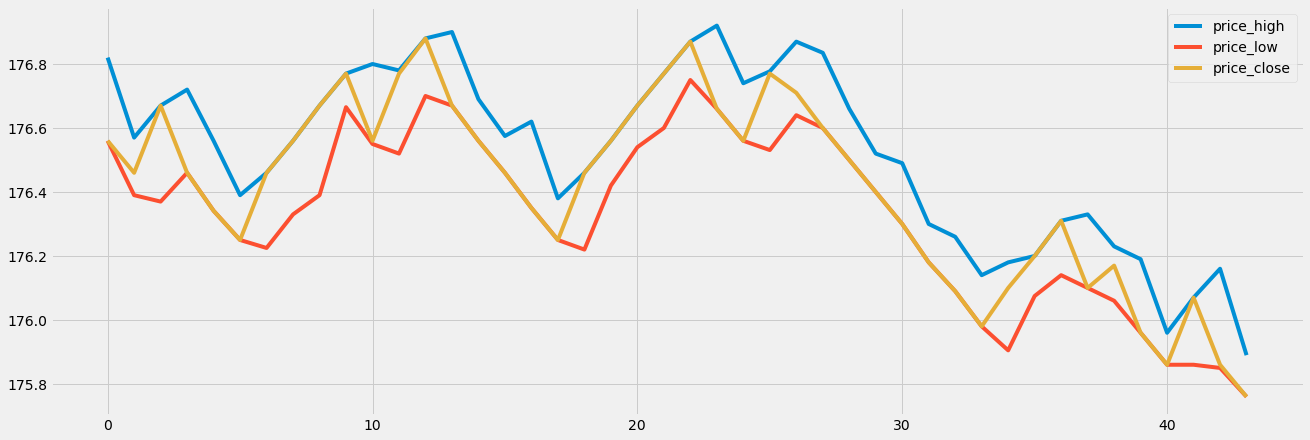

In [96]:
bdf[['price_high', 'price_low', 'price_close']].plot()

In [80]:
tdf.status.value_counts()/tdf.shape[0]

clean: market-open              0.958841
clean: pre-market               0.028502
clean: after-hours              0.005148
filtered: irregular condition   0.004090
filtered: mad_outlier           0.001600
filtered: ts diff               0.000942
filtered: mad_warmup            0.000839
filtered: zero volume           0.000039
Name: status, dtype: float64

In [ ]:
n = 0

# bds[n]['ticks_df'].price_median_diff_median.plot_bokeh(sizing_mode="scale_height")
bds[n]['ticks_df'].price_median_diff_median.plot()

In [ ]:
bds[n]['ticks_df'][['price', 'price_jma']].plot()

bds[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

In [ ]:
bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot()
# bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

In [ ]:
# bds[n]['batches_df'].set_index('close_at')[['price_jma']].ffill().plot()
bds[n]['batches_df'][['price_jma']].ffill().plot()

In [ ]:
# bds[n]['bars_df'].set_index('close_at')[['price_vwap']].plot()

bds[n]['bars_df'][['price_high', 'price_low', 'price_close']].plot()

# opening_bars_df = bds[n]['bars_df'][bds[n]['bars_df'].open_at.dt.time <= dt.time(hour=9, minute=35)]

In [ ]:
t=bds[n]['bars_df'].copy()
t.label_rrr.value_counts()/t.shape[0]

In [ ]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

In [ ]:
stats_df.describe()

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

In [ ]:
results = []

for date in bds:
    bars_df = date['bars_df'].copy()
    rrr = (abs(bars_df.label_rrr).value_counts() / bars_df.shape[0]).to_dict()
#     rrr = (abs(bars_df.label_rrr).value_counts()).to_dict()
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    out.update(rrr)
    results.append(out)

pd.DataFrame(results)